In [469]:
import numpy as np
import pickle
import networkx as nx
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import random
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.datasets import fetch_20newsgroups
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
import pickle
import numpy as np

def init_plotting():
    # plt.rcParams['font.family'] = 'Times New Roman'
    plt.rcParams["figure.figsize"] = [20, 16]
    plt.rcParams['pdf.fonttype'] = 42
    plt.rcParams['font.size'] = 22
    plt.rcParams['axes.labelsize'] = 1.8 * plt.rcParams['font.size']
    plt.rcParams['axes.titlesize'] = 1.8 * plt.rcParams['font.size']
    plt.rcParams['legend.fontsize'] = 1.1 * plt.rcParams['font.size']
    plt.rcParams['xtick.labelsize'] = 1.8 * plt.rcParams['font.size']
    plt.rcParams['ytick.labelsize'] = 1.8 * plt.rcParams['font.size']
    plt.rcParams.update({'figure.autolayout': True})

init_plotting()

def exp_smooth(vals, gamma=.85):
    res = [vals[0]]
    tv = res[0]
    for v in vals[1:]:
        tv = gamma * tv  + (1-gamma) * v
        res.append(tv)
    return res
methods = ['EC2', 'IG', 'US']
c1, c2, c3, c4 = '#d7191c', '#2b83ba', '#4dac26', '#ed9722'
cs = [c1, c2, c3, c4]
cs = {
    methods[0]:c1,
    methods[1]:c2,
    methods[2]:c3,
    'random': '#2F172E',
    'VFDT': c4,
    'EFDT': '#3f1f51'
}

In [470]:
def estimate_priors_and_theta(dataset, rand_state):
    #Prepare data
    global params
    if 'csv' in dataset:
        data_csv = pd.read_csv(dataset,header=None)
        data_csv.columns = [0, 1, 2, 3, 4, 5, 6, 'label']
        X_train, X_test, y_train, y_test = train_test_split(data_csv[[0, 1, 2, 3, 4, 5, 6]], data_csv['label'], test_size=0.5, random_state=rand_state)
    
    if dataset == '20newsgroup':
        vectorizer = TfidfVectorizer(stop_words='english',max_features=150)
        newsgroups = fetch_20newsgroups(subset='all')
        X = vectorizer.fit_transform(newsgroups.data).toarray()
        X_train, X_test, y_train, y_test = train_test_split(X, newsgroups.target,test_size=0.11, random_state=rand_state)
        X_train = (X_train>0.08)*1
        X_test = (X_test>0.08)*1
        y_train = pd.DataFrame(y_train, columns=['label'])
        X_train = pd.DataFrame(X_train)
        y_test = pd.DataFrame(y_test, columns=['label'])
        X_test = pd.DataFrame(X_test)
    
    if dataset == 'chess':
        print('dataset is chess')
        chess_data = pd.read_csv('kr-vs-kp.csv', header=None)
        onehotencoded = pd.DataFrame(OneHotEncoder().fit_transform(np.array(chess_data.iloc[:,14]).reshape(-1,1)).todense())
        chess_data = chess_data.drop(14, axis=1)
        chess_data = pd.concat([onehotencoded, chess_data], axis=1)
        chess_data = chess_data.apply(LabelEncoder().fit_transform)
        chess_data.columns = list(range(len(chess_data.columns)))
        chess_data.rename(columns={38: 'label'}, inplace=True)
        X_train, X_test, y_train, y_test = train_test_split(chess_data.iloc[:,:-1], chess_data['label'], test_size=0.7, random_state=rand_state)
        
    if dataset == 'nursery':
        nursery_data = pd.read_csv('nursery.data.csv', header=None)
        onehotencoded = pd.DataFrame(OneHotEncoder().fit_transform(np.array(nursery_data.iloc[:,:7])).todense())
        labels = pd.DataFrame(LabelEncoder().fit_transform(nursery_data.iloc[:, 8]))
        nursery_data = pd.concat([onehotencoded, labels], axis=1)
        nursery_data.columns = list(range(len(nursery_data.columns)-1))+['label']
        X_train, X_test, y_train, y_test = train_test_split(nursery_data.iloc[:,:-1], nursery_data['label'], test_size=0.7, random_state=rand_state)
        
    if dataset == 'car':
        car_data = pd.read_csv('car.data.csv', header=None)
        onehotencoded = pd.DataFrame(OneHotEncoder().fit_transform(np.array(car_data.iloc[:,:6])).todense())
        labels = pd.DataFrame(LabelEncoder().fit_transform(car_data.iloc[:, 6]))
        car_data = pd.concat([onehotencoded, labels], axis=1)
        car_data.columns = list(range(len(car_data.columns)-1))+['label']
        X_train, X_test, y_train, y_test = train_test_split(car_data.iloc[:,:-1], car_data['label'], test_size=0.7, random_state=rand_state)
    
    if dataset == 'votes':
        votes_data = pd.read_csv('house-votes-84.csv', header=None)
        encoded = votes_data.apply(LabelEncoder().fit_transform)
        votes_data = encoded
        votes_data.columns = ['label']+list(range(len(votes_data.columns)-1))
        X_train, X_test, y_train, y_test = train_test_split(votes_data.iloc[:,1:], votes_data['label'], test_size=0.8, random_state=rand_state)
    
    if dataset == 'zoo':
        zoo_data = pd.read_csv('zoo.csv')
        labels = pd.DataFrame(zoo_data['class_type']-1)
        features = list(zoo_data.columns)

        features.remove('class_type')
        features.remove('animal_name')
        features.remove('legs')

        zoo_data = pd.concat([zoo_data[features], labels], axis=1)
        zoo_data.columns = list(range(len(zoo_data.columns)-1))+['label']
        X_train, X_test, y_train, y_test = train_test_split(zoo_data.iloc[:,:-1], zoo_data['label'], test_size=0.7, random_state=rand_state)
    
    if dataset == 'heart':
        heart_data = pd.read_csv('heart.csv')
        labels = pd.DataFrame(heart_data['OVERALL_DIAGNOSIS'])
        features = list(heart_data.columns)
        features.remove('OVERALL_DIAGNOSIS')

        heart_data = pd.concat([heart_data[features], labels], axis=1)
        heart_data.columns = list(range(len(heart_data.columns)-1))+['label']
        X_train, X_test, y_train, y_test = train_test_split(heart_data.iloc[:,:-1], heart_data['label'], test_size=0.7, random_state=rand_state)
    
    if dataset == 'birds':
        bird_data = pd.read_csv('birds.csv', header=None, delimiter=",")
        labels = pd.DataFrame(bird_data[312])
        features = list(bird_data.columns)
        features.remove(312)

        bird_data = pd.concat([bird_data[features], labels], axis=1)
        bird_data.columns = list(range(len(bird_data.columns)-1))+['label']
        bird_data = bird_data[bird_data['label'] < 30]
        bird_data = bird_data[list(range(30))+['label']]
        X_train, X_test, y_train, y_test = train_test_split(bird_data.iloc[:,:-1], bird_data['label'], test_size=0.7, random_state=rand_state)
    
    
    
    data_csv = pd.concat([X_train,y_train], axis=1)
    test_csv = pd.concat([X_test,y_test], axis=1)
    
    num_features = data_csv.shape[1]-1
    num_classes = len(np.unique(test_csv['label'].to_numpy()))
    
    params = np.ones((num_classes, num_features, 2))
    theta = np.random.beta(params[:,:,0], params[:,:,1])
    
    possible_ys = sorted(list(set(test_csv['label'].to_numpy())))
    priors = []
    for l in possible_ys:
        priors.append(1.0/len(possible_ys))
        
    
    return theta, np.array(priors), test_csv, data_csv
    
    
    


In [473]:
datasets = ['data_big.csv', 'votes', 'zoo', 'heart', 'birds']
dataset = datasets[0]


In [474]:
import pickle
theta, priors, test_csv, data_csv = estimate_priors_and_theta(dataset, rand_state=100)

In [475]:
[total_accuracy_progress_EC2, total_accuracy_progress_EC2_epsgreedy, total_accuracy_progress_IG_epsgreedy, total_accuracy_progress_IG, total_accuracy_progress_US] = pickle.load(open("total_dics_"+dataset+".pkl", "rb" ) )

In [476]:
[norm_progress_EC2, norm_progress_EC2_epsgreedy, norm_progress_IG_epsgreedy, norm_progress_IG, norm_progress_US, utility_progress_EC2, utility_progress_EC2_epsgreedy, utility_progress_IG_epsgreedy, utility_progress_IG, utility_progress_US, numtest_progress_EC2, numtest_progress_EC2_epsgreedy, numtest_progress_IG_epsgreedy, numtest_progress_IG, numtest_progress_US, sums_all_EC2, sums_all_EC2_epsgreedy, sums_all_IG_epsgreedy, sums_all_IG, sums_all_US, utility_all_EC2, utility_all_EC2_epsgreedy, utility_all_IG_epsgreedy, utility_all_IG, utility_all_US] = pickle.load(open("dics_"+dataset+".pkl", "rb" ) )

In [478]:
random_states=list(range(102,112))
#########################################
# For 'data_big.csv' use the following
random_states=list(range(102,106))
########################################
norm_progress_EC2.keys()

dict_keys([5, 15, 25, 35, 45, 55, 65, 75, 85, 95])

In [479]:
numtests_mean_EC2 = [np.mean(np.array(x)/len(test_csv)) for x in sums_all_EC2.values()]
numtests_mean_EC2_epsgreedy = [np.mean(np.array(x)/len(test_csv)) for x in sums_all_EC2_epsgreedy.values()]
numtests_mean_IG = [np.mean(np.array(x)/len(test_csv)) for x in sums_all_IG.values()]
numtests_mean_IG_epsgreedy = [np.mean(np.array(x)/len(test_csv)) for x in sums_all_IG_epsgreedy.values()]
numtests_mean_US = [np.mean(np.array(x)/len(test_csv)) for x in sums_all_US.values()]


numtests_std_EC2 = [np.std(np.array(x)/len(test_csv)) for x in sums_all_EC2.values()]
numtests_std_EC2_epsgreedy = [np.std(np.array(x)/len(test_csv)) for x in sums_all_EC2_epsgreedy.values()]
numtests_std_IG = [np.std(np.array(x)/len(test_csv)) for x in sums_all_IG.values()]
numtests_std_IG_epsgreedy = [np.std(np.array(x)/len(test_csv)) for x in sums_all_IG_epsgreedy.values()]
numtests_std_US = [np.std(np.array(x)/len(test_csv)) for x in sums_all_US.values()]

/Users/armanr/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/armanr/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/armanr/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/armanr/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/armanr/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


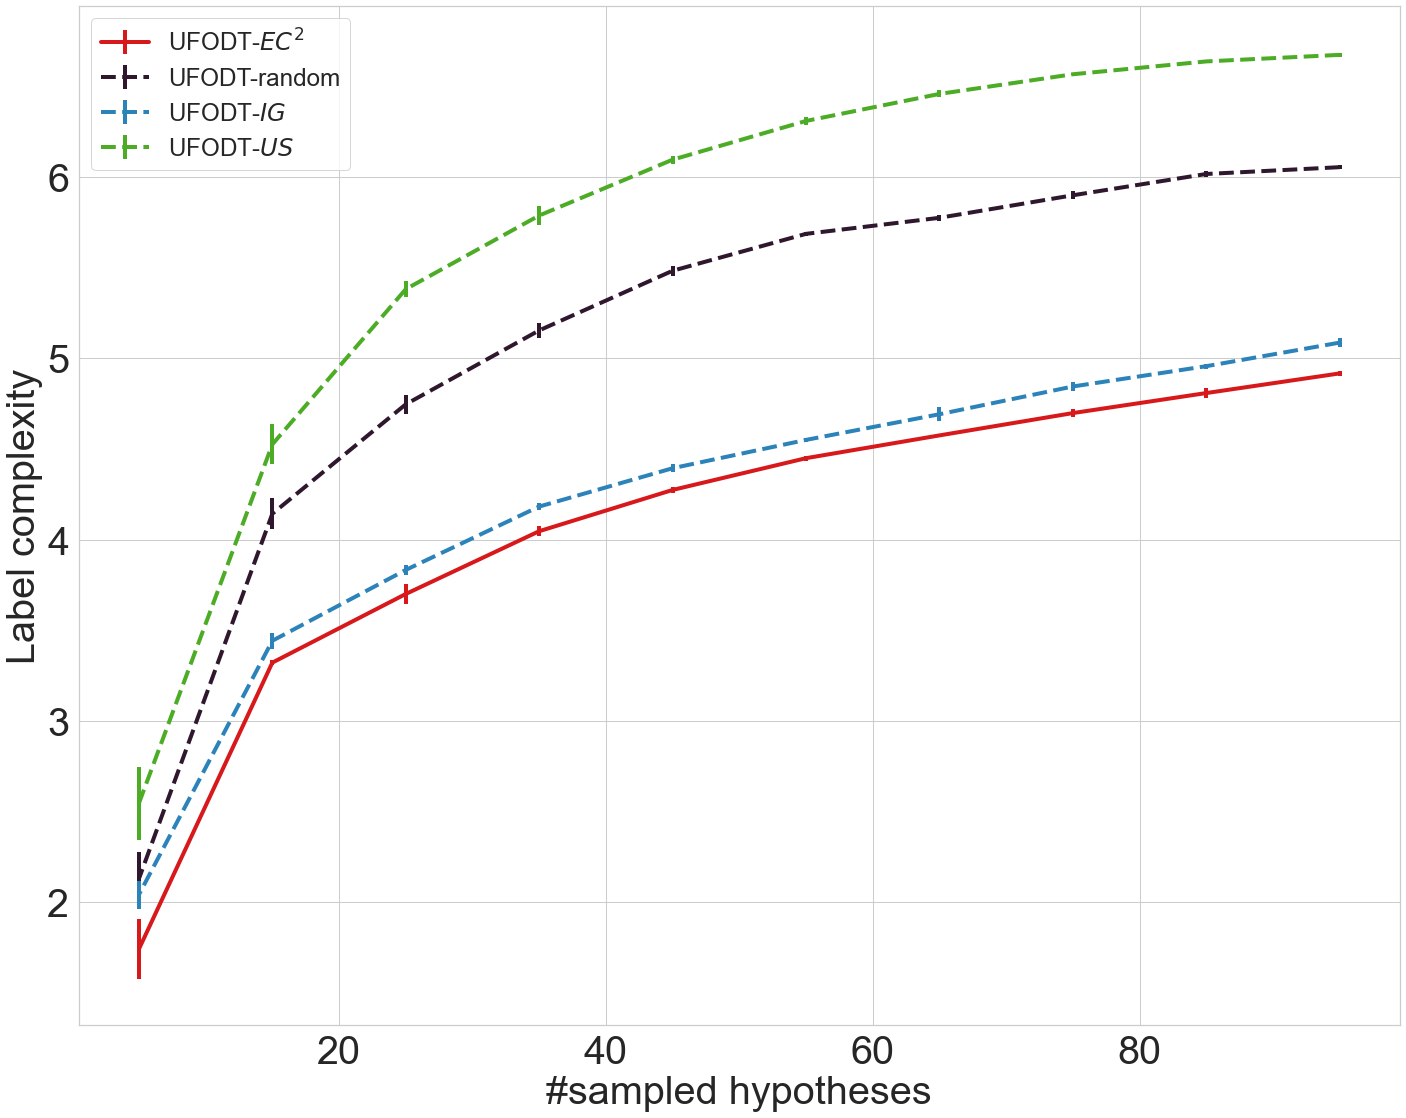

In [480]:
num_samples = list(sums_all_EC2.keys())
numtests_mean_EC2.reverse()
numtests_mean_EC2_epsgreedy.reverse()
numtests_mean_IG.reverse()
numtests_mean_IG_epsgreedy.reverse()
numtests_mean_US.reverse()
numtests_std_EC2.reverse()
numtests_std_EC2_epsgreedy.reverse()
numtests_std_IG.reverse()
numtests_std_IG_epsgreedy.reverse()
numtests_std_US.reverse()
num_samples.reverse()



plt.figure()
plt.errorbar(num_samples, numtests_mean_EC2, yerr=numtests_std_EC2/np.sqrt(len(random_states)), color=cs['EC2'],linestyle='-', linewidth=4, label=r"UFODT-$EC^2$")
# plt.errorbar(num_samples, numtests_mean_EC2_epsgreedy, yerr=numtests_std_EC2_epsgreedy,linestyle='-', label=r"Online $\epsilon$-greedy $EC^2$")
plt.errorbar(num_samples, numtests_mean_IG_epsgreedy, yerr=numtests_std_IG_epsgreedy/np.sqrt(len(random_states)), color=cs['random'],linestyle='--', linewidth=4, label=r"UFODT-random")
plt.errorbar(num_samples, numtests_mean_IG, yerr=numtests_std_IG/np.sqrt(len(random_states)), color=cs['IG'],linestyle='--', linewidth=4, label=r"UFODT-$IG$")
plt.errorbar(num_samples, numtests_mean_US, yerr=numtests_std_US/np.sqrt(len(random_states)), color=cs['US'],linestyle='--', linewidth=4, label=r"UFODT-$US$")
plt.xlabel('#sampled hypotheses')
plt.ylabel('Label complexity')
plt.legend()
plt.savefig('Results/'+dataset+'/label_complexity_online'+dataset+'.eps', format='eps')


In [481]:
for k in utility_all_EC2.keys():
    utility_all_EC2[k] = [x[0] for x in utility_all_EC2[k]]
    utility_all_EC2_epsgreedy[k] = [x[0] for x in utility_all_EC2_epsgreedy[k]]
    utility_all_IG_epsgreedy[k] = [x[0] for x in utility_all_IG_epsgreedy[k]]
    utility_all_IG[k] = [x[0] for x in utility_all_IG[k]]
    utility_all_US[k] = [x[0] for x in utility_all_US[k]]
    

In [482]:



utility_mean_EC2 = [np.mean(np.array(x)) for x in utility_all_EC2.values()]
utility_mean_EC2_epsgreedy = [np.mean(np.array(x)) for x in utility_all_EC2_epsgreedy.values()]
utility_mean_IG_epsgreedy = [np.mean(np.array(x)) for x in utility_all_IG_epsgreedy.values()]
utility_mean_IG = [np.mean(np.array(x)) for x in utility_all_IG.values()]
utility_mean_US = [np.mean(np.array(x)) for x in utility_all_US.values()]


utility_std_EC2 = [np.std(np.array(x)) for x in utility_all_EC2.values()]
utility_std_EC2_epsgreedy = [np.std(np.array(x)) for x in utility_all_EC2_epsgreedy.values()]
utility_std_IG_epsgreedy = [np.std(np.array(x)) for x in utility_all_IG_epsgreedy.values()]
utility_std_IG = [np.std(np.array(x)) for x in utility_all_IG.values()]
utility_std_US = [np.std(np.array(x)) for x in utility_all_US.values()]

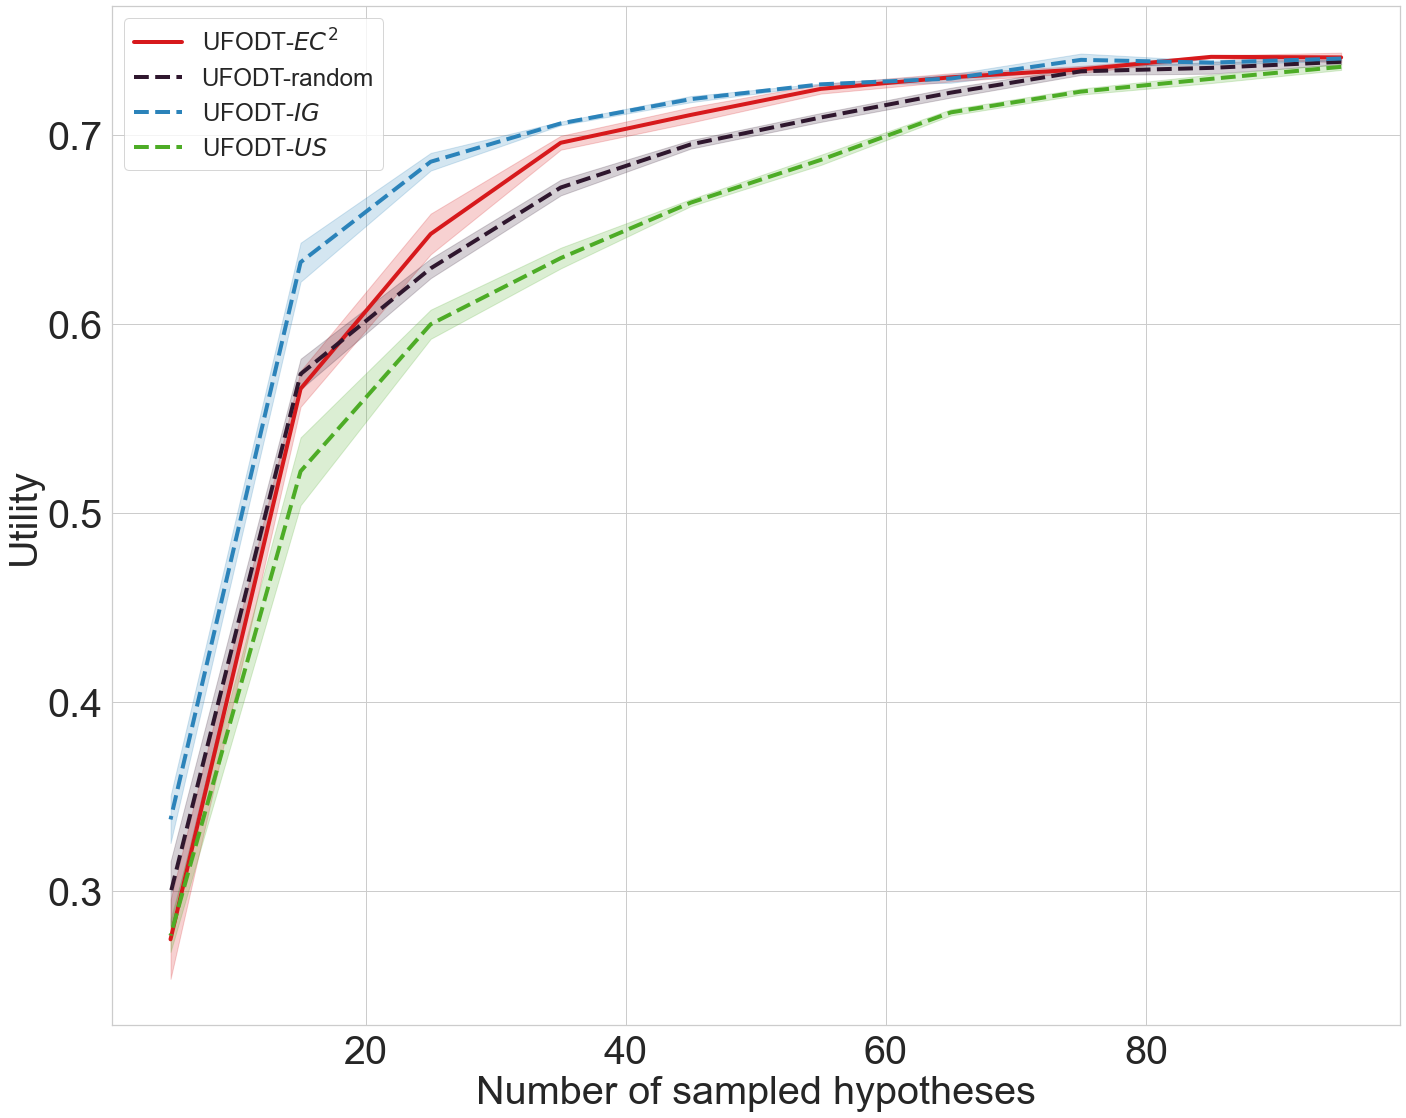

In [483]:
num_samples = list(utility_all_EC2.keys())
utility_mean_EC2.reverse()
utility_mean_EC2_epsgreedy.reverse()
utility_mean_IG_epsgreedy.reverse()
utility_mean_IG.reverse()
utility_mean_US.reverse()
utility_std_EC2.reverse()
utility_std_EC2_epsgreedy.reverse()
utility_std_IG_epsgreedy.reverse()
utility_std_IG.reverse()
utility_std_US.reverse()
num_samples.reverse()



plt.figure()
plt.plot(num_samples, utility_mean_EC2, linestyle='-', label=r"UFODT-$EC^2$", linewidth=4, color=cs['EC2'])
# plt.plot(num_samples, utility_mean_EC2_epsgreedy, linestyle='-', label=r"Online $\epsilon$-greedy $EC^2$")
plt.plot(num_samples, utility_mean_IG_epsgreedy, linestyle='--', label=r"UFODT-random", linewidth=4, color=cs['random'])
plt.plot(num_samples, utility_mean_IG, linestyle='--', label=r"UFODT-$IG$", linewidth=4, color=cs['IG'])
plt.plot(num_samples, utility_mean_US, linestyle='--', label=r"UFODT-$US$", linewidth=4, color=cs['US'])



plt.fill_between(num_samples, np.array(utility_mean_EC2)-np.array(utility_std_EC2)/np.sqrt(len(random_states)), np.array(utility_mean_EC2)+np.array(utility_std_EC2)/np.sqrt(len(random_states)),alpha=0.2,  color=cs['EC2'])
# plt.fill_between(num_samples, np.array(utility_mean_EC2_epsgreedy)-np.array(utility_std_EC2_epsgreedy), np.array(utility_mean_EC2_epsgreedy)+np.array(utility_std_EC2_epsgreedy),alpha=0.2)
plt.fill_between(num_samples, np.array(utility_mean_IG_epsgreedy)-np.array(utility_std_IG_epsgreedy)/np.sqrt(len(random_states)), np.array(utility_mean_IG_epsgreedy)+np.array(utility_std_IG_epsgreedy)/np.sqrt(len(random_states)),alpha=0.2,  color=cs['random'])
plt.fill_between(num_samples, np.array(utility_mean_IG)-np.array(utility_std_IG)/np.sqrt(len(random_states)), np.array(utility_mean_IG)+np.array(utility_std_IG)/np.sqrt(len(random_states)),alpha=0.2, color=cs['IG'])
plt.fill_between(num_samples, np.array(utility_mean_US)-np.array(utility_std_US)/np.sqrt(len(random_states)), np.array(utility_mean_US)+np.array(utility_std_US)/np.sqrt(len(random_states)), facecolor='r',alpha=0.2,  color=cs['US'])


plt.xlabel('Number of sampled hypotheses')
plt.ylabel('Utility')
# plt.ylim(0.47,0.7)
plt.legend()
plt.gca().set_rasterized(True)
plt.savefig('Results/'+dataset+'/Utility_online'+dataset+'.pdf', format='pdf')



In [484]:
utils_EC2 = []
numtests_EC2 = []
for u,n in zip(utility_mean_EC2, numtests_mean_EC2):
    utils_EC2.append(u)
    numtests_EC2.append(n)
    
utils_EC2_epsgreedy = []
numtests_EC2_epsgreedy = []
for u,n in zip(utility_mean_EC2_epsgreedy, numtests_mean_EC2_epsgreedy):
    utils_EC2_epsgreedy.append(u)
    numtests_EC2_epsgreedy.append(n)
    
utils_IG_epsgreedy = []
numtests_IG_epsgreedy = []
for u,n in zip(utility_mean_IG_epsgreedy, numtests_mean_IG_epsgreedy):
    utils_IG_epsgreedy.append(u)
    numtests_IG_epsgreedy.append(n)
    
utils_IG = []
numtests_IG = []
for u,n in zip(utility_mean_IG, numtests_mean_IG):
    utils_IG.append(u)
    numtests_IG.append(n)
    
utils_US = []
numtests_US = []
for u,n in zip(utility_mean_US, numtests_mean_US):
    utils_US.append(u)
    numtests_US.append(n)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


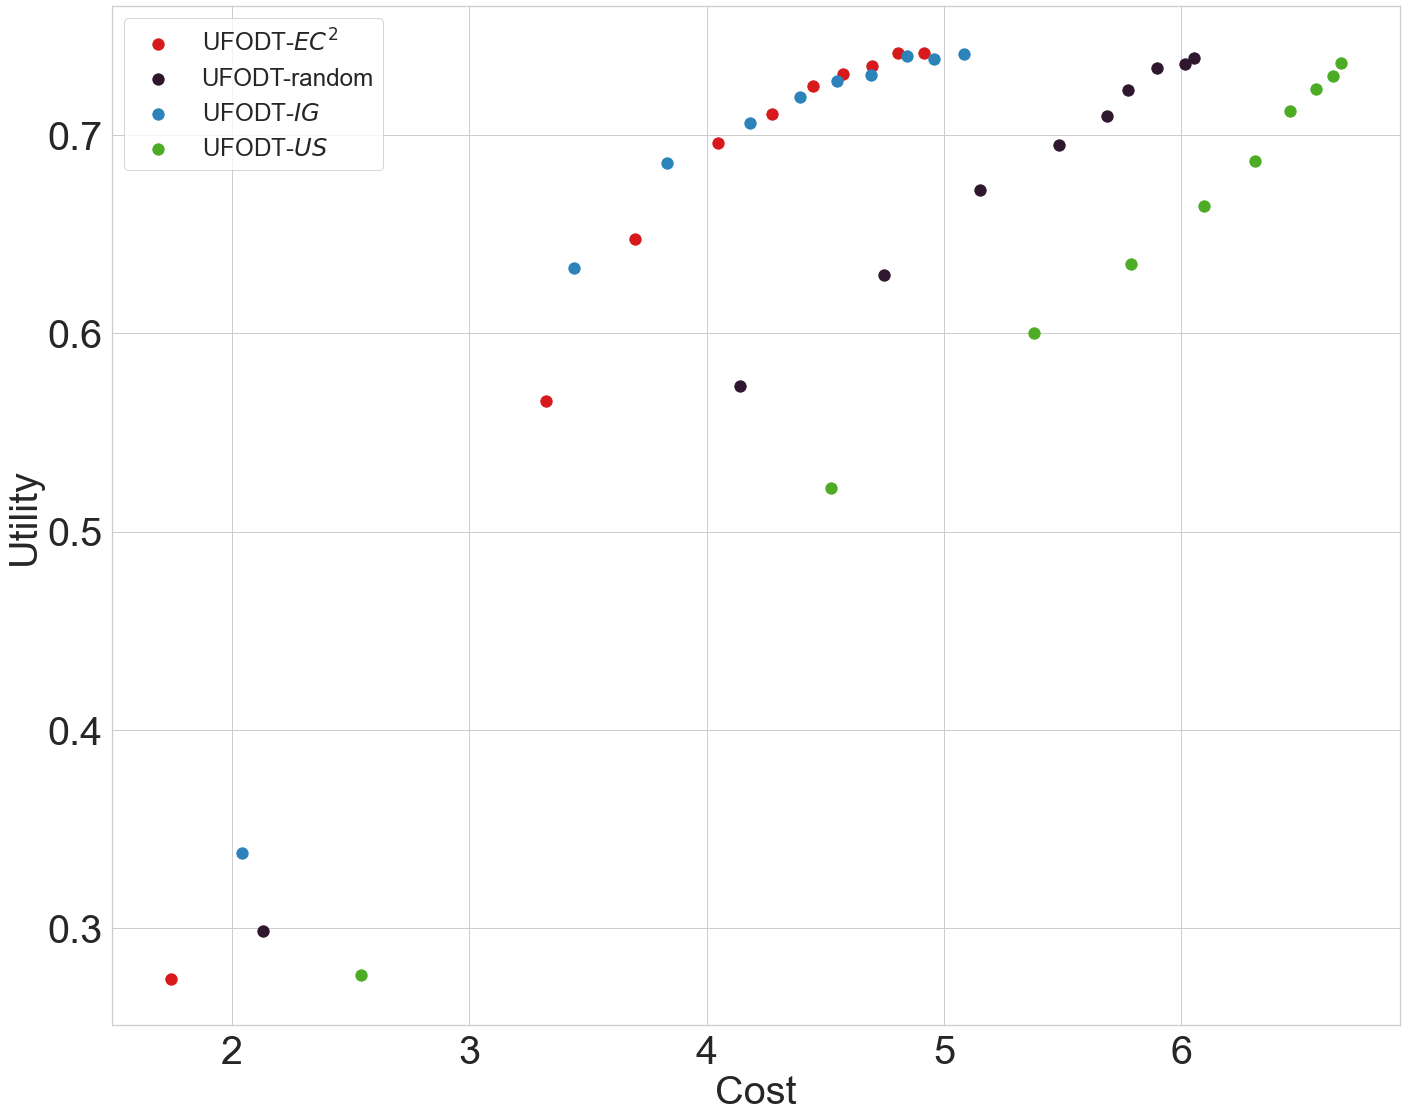

In [485]:
plt.figure()
plt.scatter(numtests_EC2, utils_EC2, label=r"UFODT-$EC^2$", color=cs['EC2'], s=128)
# plt.scatter(numtests_EC2_epsgreedy, utils_EC2_epsgreedy, label=r"Online $\epsilon$-greedy $EC^2$")
plt.scatter(numtests_IG_epsgreedy, utils_IG_epsgreedy, label=r"UFODT-random", color=cs['random'], s=128)
plt.scatter(numtests_IG, utils_IG, label=r"UFODT-$IG$", color=cs['IG'],s=128)
plt.scatter(numtests_US, utils_US, label=r"UFODT-$US$", color=cs['US'],s=128)
plt.legend()
plt.xlabel('Cost')
plt.ylabel('Utility')
plt.savefig('Results/'+dataset+'/UtilityVSCost_EC2_IG_US_online'+dataset+'.eps', format='eps')

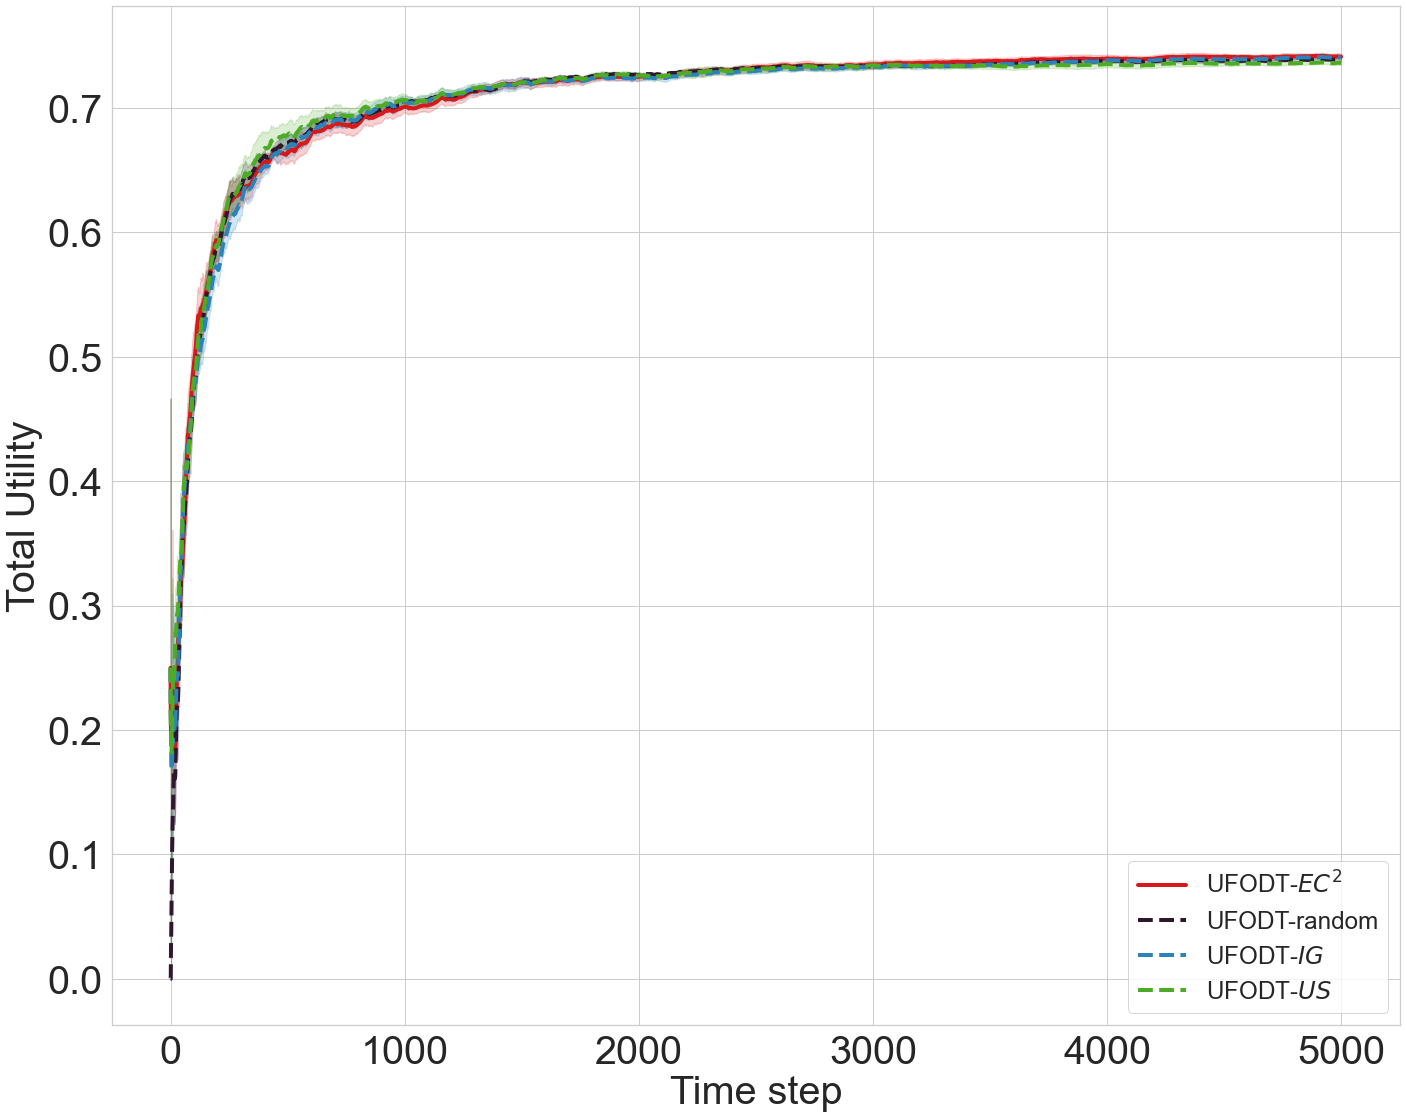

In [486]:
#heart-->34
#votes-->40
#zoo-->161
#data_big.csv-->95

num_hypo_in_plot = 95
plt.figure()
plt.xlabel('Time step')
plt.ylabel('Total Utility')

to_plot_array = np.array(utility_progress_EC2[num_hypo_in_plot][0]).reshape(len(random_states),-1)
plt.plot(exp_smooth(np.mean(to_plot_array, axis=0), 0.7),linestyle='-', label=r"UFODT-$EC^2$", linewidth=4, color=cs['EC2'])
plt.fill_between(range(to_plot_array.shape[1]),
                 np.mean(to_plot_array, axis=0)-np.std(to_plot_array, axis=0)/np.sqrt(len(random_states)),
                 np.mean(to_plot_array, axis=0)+np.std(to_plot_array, axis=0)/np.sqrt(len(random_states)),
                 alpha=0.2,
                color=cs['EC2'])

to_plot_array = np.array(utility_progress_IG_epsgreedy[num_hypo_in_plot][0]).reshape(len(random_states),-1)
plt.plot(exp_smooth(np.mean(to_plot_array, axis=0), 0.7),linestyle='--', label=r"UFODT-random", linewidth=4, color=cs['random'])
plt.fill_between(range(to_plot_array.shape[1]),
                 np.mean(to_plot_array, axis=0)-np.std(to_plot_array, axis=0)/np.sqrt(len(random_states)),
                 np.mean(to_plot_array, axis=0)+np.std(to_plot_array, axis=0)/np.sqrt(len(random_states)),
                 alpha=0.2,
                color=cs['random'])

# to_plot_array = np.array(utility_progress_EC2_epsgreedy[num_hypo_in_plot][0]).reshape(5,-1)
# plt.plot(np.mean(to_plot_array, axis=0),linestyle='-', label=r"Online $\epsilon$-greedy $EC^2$")
# plt.fill_between(range(to_plot_array.shape[1]),np.mean(to_plot_array, axis=0)-np.std(to_plot_array, axis=0), np.mean(to_plot_array, axis=0)+np.std(to_plot_array, axis=0),alpha=0.2)

to_plot_array = np.array(utility_progress_IG[num_hypo_in_plot][0]).reshape(len(random_states),-1)
plt.plot(exp_smooth(np.mean(to_plot_array, axis=0), 0.7),linestyle='--', label=r"UFODT-$IG$", linewidth=4, color=cs['IG'])
plt.fill_between(range(to_plot_array.shape[1]),
                 np.mean(to_plot_array, axis=0)-np.std(to_plot_array, axis=0)/np.sqrt(len(random_states)),
                 np.mean(to_plot_array, axis=0)+np.std(to_plot_array, axis=0)/np.sqrt(len(random_states)),
                 alpha=0.2,
                color=cs['IG'])

to_plot_array = np.array(utility_progress_US[num_hypo_in_plot][0]).reshape(len(random_states),-1)
plt.plot(exp_smooth(np.mean(to_plot_array, axis=0), 0.7),linestyle='--', label=r"UFODT-$US$", linewidth=4, color=cs['US'])
plt.fill_between(range(to_plot_array.shape[1]),
                 np.mean(to_plot_array, axis=0)-np.std(to_plot_array, axis=0)/np.sqrt(len(random_states)),
                 np.mean(to_plot_array, axis=0)+np.std(to_plot_array, axis=0)/np.sqrt(len(random_states)),
                 alpha=0.2,
                color=cs['US'])



plt.legend()
# plt.ylim(0.68, 0.75)

plt.savefig('Results/'+dataset+'/Utility_in_progress_num_hypo_'+str(num_hypo_in_plot)+'_'+dataset+'.pdf', format='pdf')


# Plot Costs

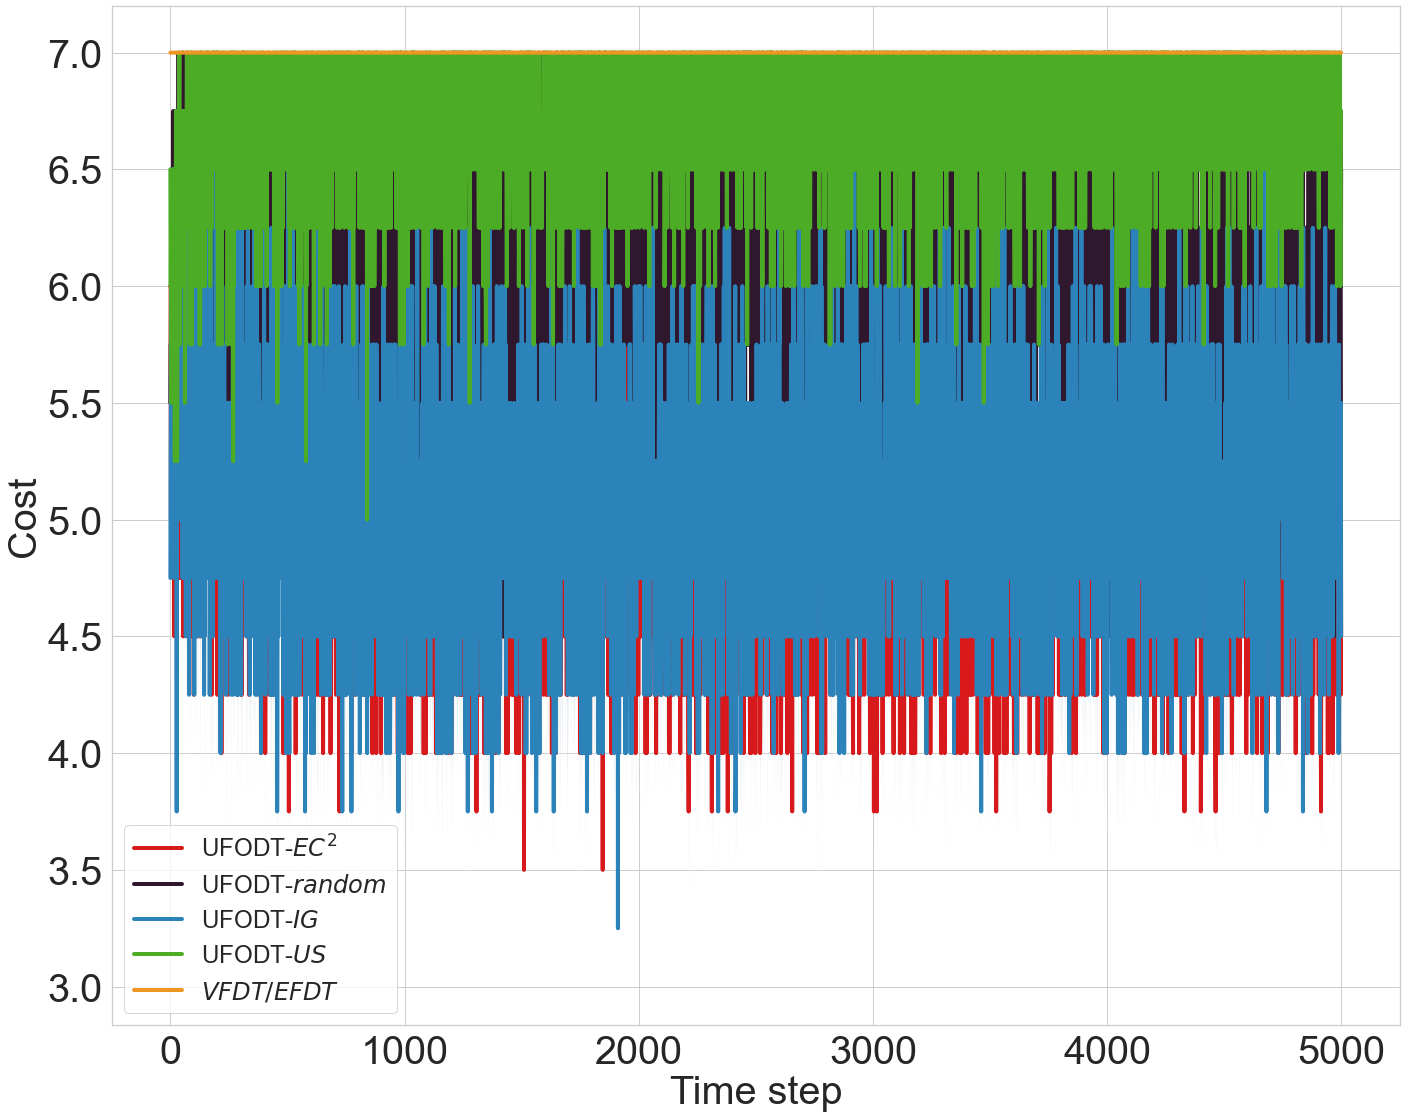

In [487]:
#heart-->34
#votes-->40
#zoo-->161
#data_big.csv-->95

num_hypo_in_plot = 95
plt.figure()
plt.xlabel('Time step')
plt.ylabel('Cost')

to_plot_array = np.array(numtest_progress_EC2[num_hypo_in_plot][0]).reshape(len(random_states),-1)
plt.plot(np.mean(to_plot_array, axis=0),linestyle='-', label=r"UFODT-$EC^2$", linewidth=4, color=cs['EC2'])
plt.fill_between(range(to_plot_array.shape[1]),np.mean(to_plot_array, axis=0)-np.std(to_plot_array, axis=0)/np.sqrt(len(random_states)), np.mean(to_plot_array, axis=0)+np.std(to_plot_array, axis=0)/np.sqrt(len(random_states)),alpha=0.2)

to_plot_array = np.array(numtest_progress_IG_epsgreedy[num_hypo_in_plot][0]).reshape(len(random_states),-1)
plt.plot(np.mean(to_plot_array, axis=0),linestyle='-', label=r"UFODT-$random$", linewidth=4, color=cs['random'])
plt.fill_between(range(to_plot_array.shape[1]),np.mean(to_plot_array, axis=0)-np.std(to_plot_array, axis=0)/np.sqrt(len(random_states)), np.mean(to_plot_array, axis=0)+np.std(to_plot_array, axis=0)/np.sqrt(len(random_states)),alpha=0.2)

to_plot_array = np.array(numtest_progress_IG[num_hypo_in_plot][0]).reshape(len(random_states),-1)
plt.plot(np.mean(to_plot_array, axis=0),linestyle='-', label=r"UFODT-$IG$", linewidth=4, color=cs['IG'])
plt.fill_between(range(to_plot_array.shape[1]),np.mean(to_plot_array, axis=0)-np.std(to_plot_array, axis=0)/np.sqrt(len(random_states)), np.mean(to_plot_array, axis=0)+np.std(to_plot_array, axis=0)/np.sqrt(len(random_states)),alpha=0.2)

to_plot_array = np.array(numtest_progress_US[num_hypo_in_plot][0]).reshape(len(random_states),-1)
plt.plot(np.mean(to_plot_array, axis=0),linestyle='-', label=r"UFODT-$US$", linewidth=4, color=cs['US'])
plt.fill_between(range(to_plot_array.shape[1]),np.mean(to_plot_array, axis=0)-np.std(to_plot_array, axis=0)/np.sqrt(len(random_states)), np.mean(to_plot_array, axis=0)+np.std(to_plot_array, axis=0)/np.sqrt(len(random_states)),alpha=0.2)


plt.plot([test_csv.shape[1]-1]*test_csv.shape[0],linestyle='-', label=r"$VFDT/EFDT$", linewidth=4, color=cs['VFDT'])


plt.legend()
# plt.ylim(0.68, 0.75)

plt.savefig('Results/'+dataset+'/Cost_in_progress_num_hypo_'+str(num_hypo_in_plot)+'_'+dataset+'.pdf', format='pdf')

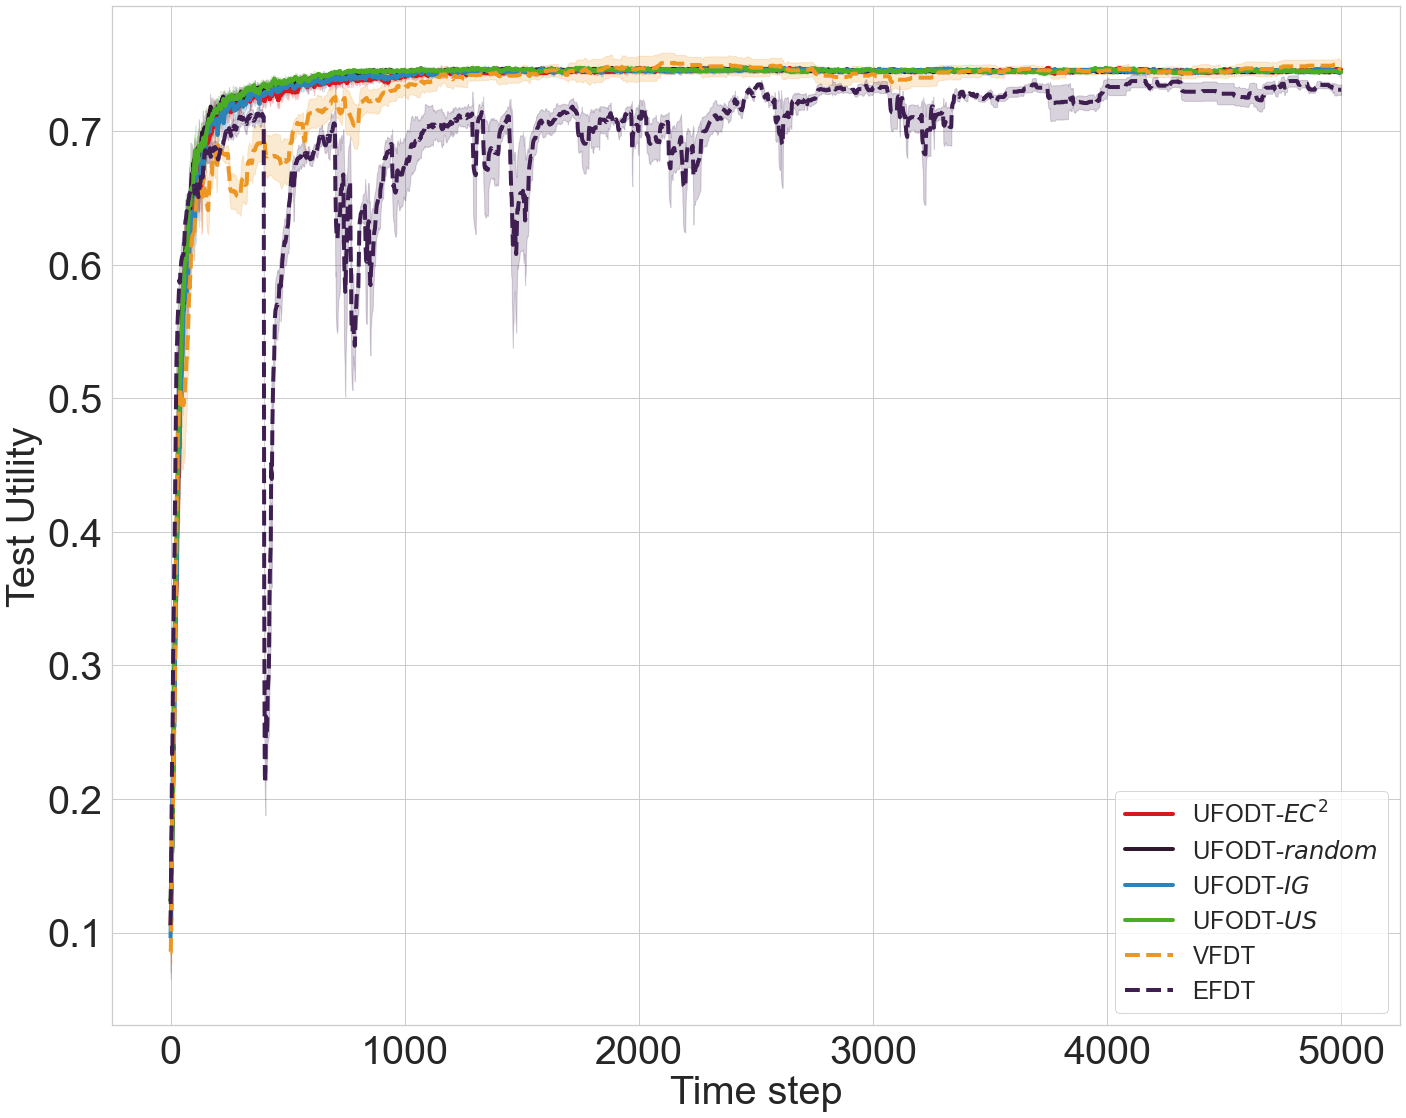

In [489]:
#heart-->34
#votes-->40
#zoo-->161
#data_big.csv-->95

num_hypo_in_plot = 95
plt.figure()
plt.xlabel('Time step')
plt.ylabel('Test Utility')

to_plot_array = np.array(total_accuracy_progress_EC2[num_hypo_in_plot][0]).reshape(len(random_states),-1)
plt.plot(exp_smooth(np.mean(to_plot_array, axis=0), 0.8),linestyle='-', label=r"UFODT-$EC^2$", linewidth=4, color=cs['EC2'])
plt.fill_between(range(to_plot_array.shape[1]),exp_smooth(np.mean(to_plot_array, axis=0), 0.8)-np.std(to_plot_array, axis=0)/np.sqrt(len(random_states)), exp_smooth(np.mean(to_plot_array, axis=0), 0.8)+np.std(to_plot_array, axis=0)/np.sqrt(len(random_states)),alpha=0.2, color=cs['EC2'])

to_plot_array = np.array(total_accuracy_progress_IG_epsgreedy[num_hypo_in_plot][0]).reshape(len(random_states),-1)
plt.plot(exp_smooth(np.mean(to_plot_array, axis=0), 0.8),linestyle='-', label=r"UFODT-$random$", linewidth=4, color=cs['random'])
plt.fill_between(range(to_plot_array.shape[1]),exp_smooth(np.mean(to_plot_array, axis=0), 0.8)-np.std(to_plot_array, axis=0)/np.sqrt(len(random_states)), exp_smooth(np.mean(to_plot_array, axis=0), 0.8)+np.std(to_plot_array, axis=0)/np.sqrt(len(random_states)),alpha=0.2, color=cs['random'])

to_plot_array = np.array(total_accuracy_progress_IG[num_hypo_in_plot][0]).reshape(len(random_states),-1)
plt.plot(exp_smooth(np.mean(to_plot_array, axis=0), 0.8),linestyle='-', label=r"UFODT-$IG$", linewidth=4, color=cs['IG'])
plt.fill_between(range(to_plot_array.shape[1]),exp_smooth(np.mean(to_plot_array, axis=0), 0.8)-np.std(to_plot_array, axis=0)/np.sqrt(len(random_states)), exp_smooth(np.mean(to_plot_array, axis=0), 0.8)+np.std(to_plot_array, axis=0)/np.sqrt(len(random_states)),alpha=0.2, color=cs['IG'])

to_plot_array = np.array(total_accuracy_progress_US[num_hypo_in_plot][0]).reshape(len(random_states),-1)
plt.plot(exp_smooth(np.mean(to_plot_array, axis=0), 0.8),linestyle='-', label=r"UFODT-$US$", linewidth=4, color=cs['US'])
plt.fill_between(range(to_plot_array.shape[1]),exp_smooth(np.mean(to_plot_array, axis=0), 0.8)-np.std(to_plot_array, axis=0)/np.sqrt(len(random_states)), exp_smooth(np.mean(to_plot_array, axis=0), 0.8)+np.std(to_plot_array, axis=0)/np.sqrt(len(random_states)),alpha=0.2, color=cs['US'])



accs = pickle.load(open("vfdt_test_utility_"+dataset+".pkl", "rb" ))
plt.plot(exp_smooth(np.mean(accs, axis=0), 0.7), linestyle='--', label=r"VFDT", linewidth=4, color=cs['VFDT'])
plt.fill_between(range(accs.shape[1]),exp_smooth(np.mean(accs, axis=0), 0.7)-np.std(accs, axis=0)/np.sqrt(len(random_states)), exp_smooth(np.mean(accs, axis=0), 0.7)+np.std(accs, axis=0)/np.sqrt(len(random_states)),alpha=0.2, color=cs['VFDT'])

accs = pickle.load(open("efdt_test_utility_"+dataset+".pkl", "rb" ))
plt.plot(exp_smooth(np.mean(accs, axis=0),0.6), linestyle='--', label=r"EFDT", linewidth=4, color=cs['EFDT'])
plt.fill_between(range(accs.shape[1]),exp_smooth(np.mean(accs, axis=0),0.6)-np.std(accs, axis=0)/np.sqrt(len(random_states)), exp_smooth(np.mean(accs, axis=0),0.6)+np.std(accs, axis=0)/np.sqrt(len(random_states)),alpha=0.2, color=cs['EFDT'])



plt.legend()
# plt.ylim(0.68, 0.76)
# plt.xlim(25, 175)

plt.savefig('Results/'+dataset+'/TestUtility_in_progress_num_hypo_'+str(num_hypo_in_plot)+'_'+dataset+'.pdf', format='pdf')